011017 Experiment notes: <br />2um electrode; <br />Square wave; <br />V$_o$$_n$ = 80 V, V$_o$$_f$$_f$ = 0 V<br /> files:
<br />..._1: 1kHz,    V start at ~13s
<br />..._2: 100Hz, V start at ~5s
<br />..._3: 10kHz, V start at ~6s
<br />..._4: 10kHz, V start at ~5s
<br />..._5: 1kHz,    V start at ~5s
<br />..._6: 100Hz, V start at ~5s
<br />..._7: 40Hz,    V start at ~5s

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
V_freq_applied = 1000.
voltage_start_time = 13.

In [3]:
fPath = '/Users/yungkuo/Google Drive/011017 H33D kQD w voltage/'

In [4]:
ts = np.fromfile(fPath+'Time Stamps/electrode_kQD_1_009.dat', dtype='>d')

In [5]:
print('Total number of photons: % d' % ts.shape) #Timestamps are in unite of seconds

Total number of photons:  88883


# Time traces with different time bin

In [6]:
bin_times = [0.1, 0.025, 0.001]

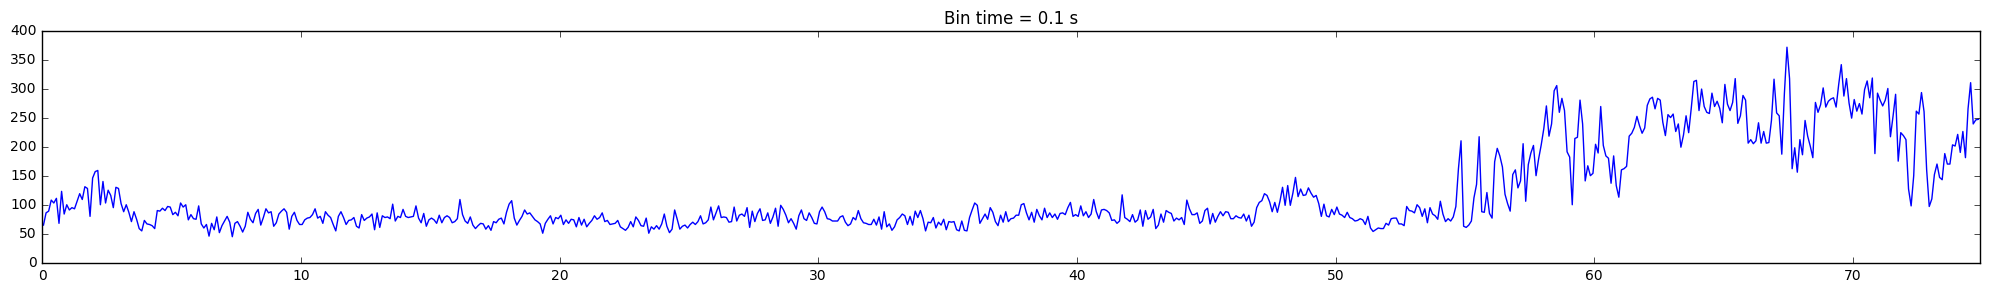

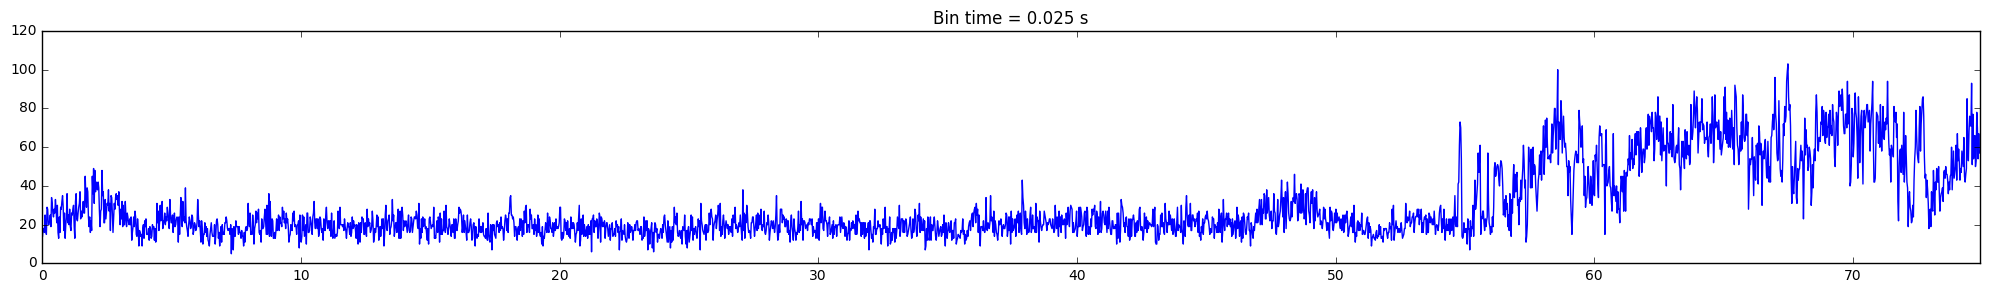

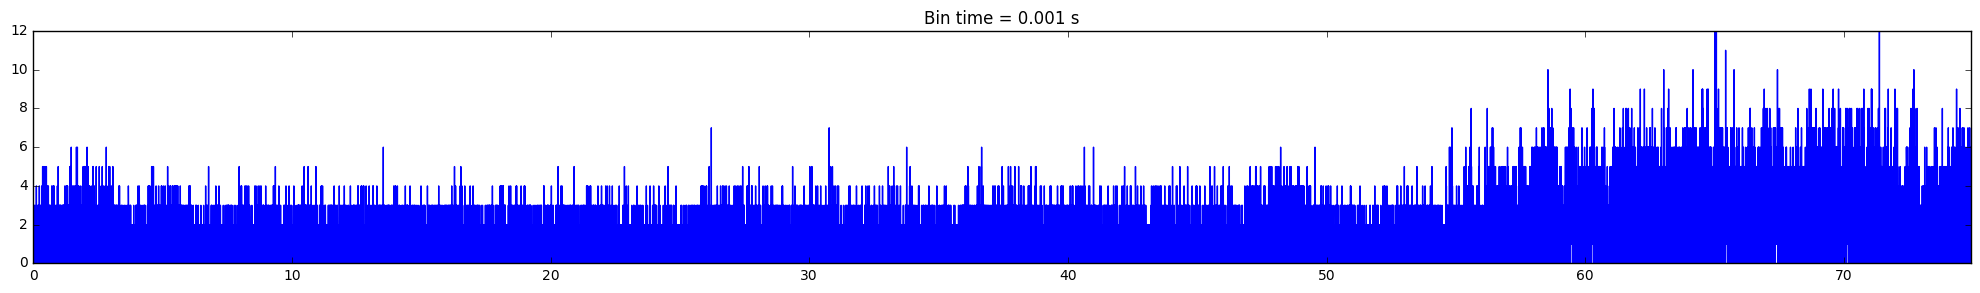

In [7]:
for i in range(len(bin_times)):
    counts, bin_edge = np.histogram(ts, bins=np.arange(0,np.max(ts),bin_times[i]))
    plt.figure(figsize=(25,3))
    plt.plot(bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2, counts)
    plt.xlim(bin_edge[0], bin_edge[-1])
    plt.title('Bin time = {} s'.format(bin_times[i]))

# FFT

In [8]:
t_bin = 0.0002 # unit: seconds

In [9]:
print('Applied V Period: %f s' % (1/V_freq_applied))
print('Applied V period / bin time: {}'.format((1/V_freq_applied)/t_bin)
      +';  >1: {}'.format((1/V_freq_applied)/t_bin >1))

Applied V Period: 0.001000 s
Applied V period / bin time: 5.0;  >1: True


In [10]:
def get_fft(ts, t_bin):
    counts, bin_edge = np.histogram(ts, bins=np.arange(np.min(ts),np.max(ts),t_bin))
    t = bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2
    sp = np.fft.fft(counts)
    freq = np.fft.fftfreq(t.shape[-1])/t_bin
    real_half = np.abs(sp.real)[:len(freq)//2]
    return (freq[:len(freq)//2], real_half)

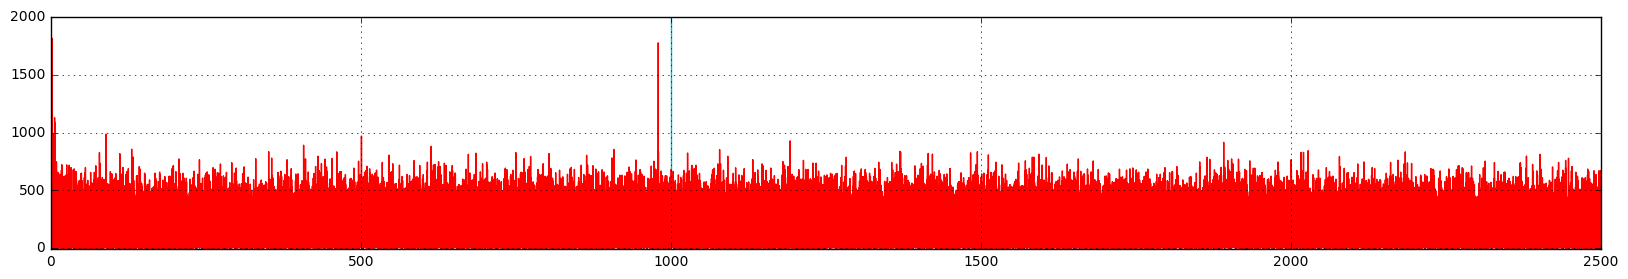

In [11]:
freq, real_half = get_fft(ts, t_bin)
plt.figure(figsize=(20,3))
plt.plot(freq, real_half, 'r')
plt.ylim(-10, 2000)
plt.vlines(x= V_freq_applied, ymin=0, ymax=plt.yticks()[0][-1], color='c')
plt.grid()

#### Extract response frequencies

In [12]:
peaks = np.where(real_half>=1000)
extracted_freqs = freq[peaks]
extracted_freqs = extracted_freqs[np.logical_and(extracted_freqs>V_freq_applied*0.9, 
                                                 extracted_freqs<V_freq_applied*1.1)]
extracted_freqs

array([ 979.22963548,  979.29638688,  979.33643772,  979.349788  ])

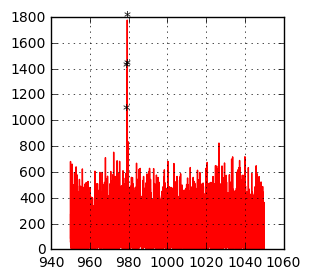

In [13]:
plt.figure(figsize=(3,3))
display_range = np.where(np.logical_and(freq>V_freq_applied*0.95, 
                                        freq<V_freq_applied*1.05))
plt.plot(freq[display_range], real_half[display_range], 'r')
plt.grid()
for i in extracted_freqs:
    peak_value = real_half[np.where(freq==i)]
    plt.annotate(s='*', xy=(i, peak_value), xytext=(-3,0), xycoords='data', textcoords='offset points')

# Average every period (wrap data)

In [14]:
Vfreq = extracted_freqs[:]#np.arange(39.5,40.1,0.05)
print('Bin time = %f s' % t_bin)
periods = 1/Vfreq

Bin time = 0.000200 s


In [15]:
Vfreq

array([ 979.22963548,  979.29638688,  979.33643772,  979.349788  ])

In [16]:
periods

array([ 0.00102121,  0.00102114,  0.0010211 ,  0.00102109])

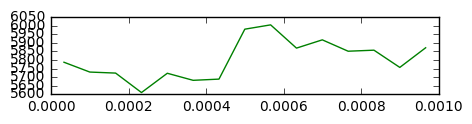

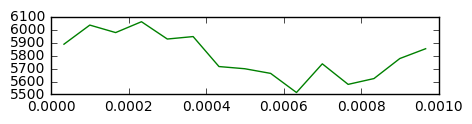

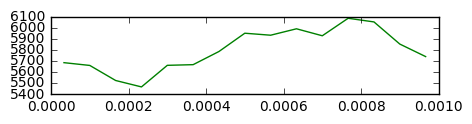

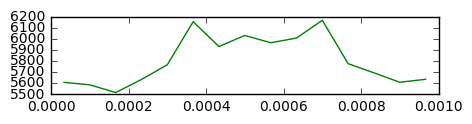

In [17]:
for period in periods:
    counts, bin_edge = np.histogram(ts%period, bins=np.arange(0,period,t_bin/3))
    plt.figure(figsize=(5,1))
    plt.plot(bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2, counts, 'g-')

# FFT at different time window

In [18]:
t_bin = t_bin
print('Bin time = %f s' % t_bin)

Bin time = 0.000200 s


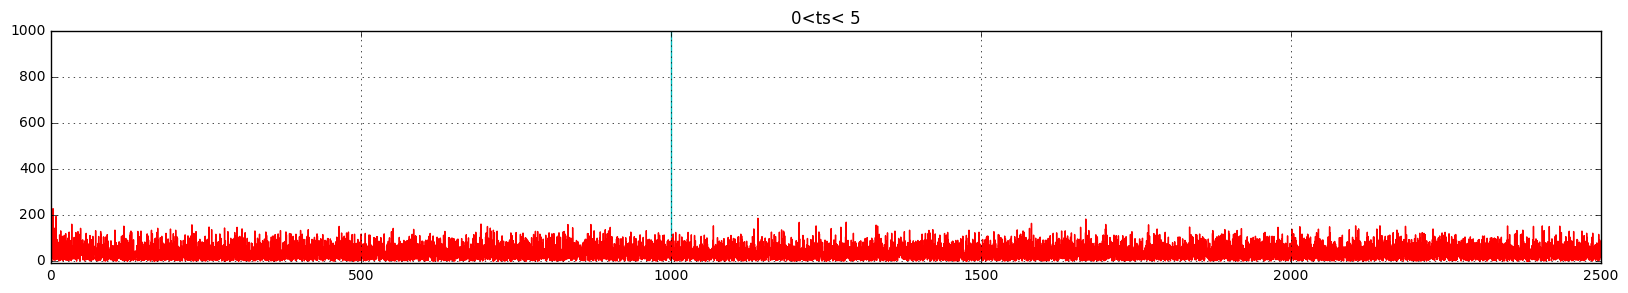

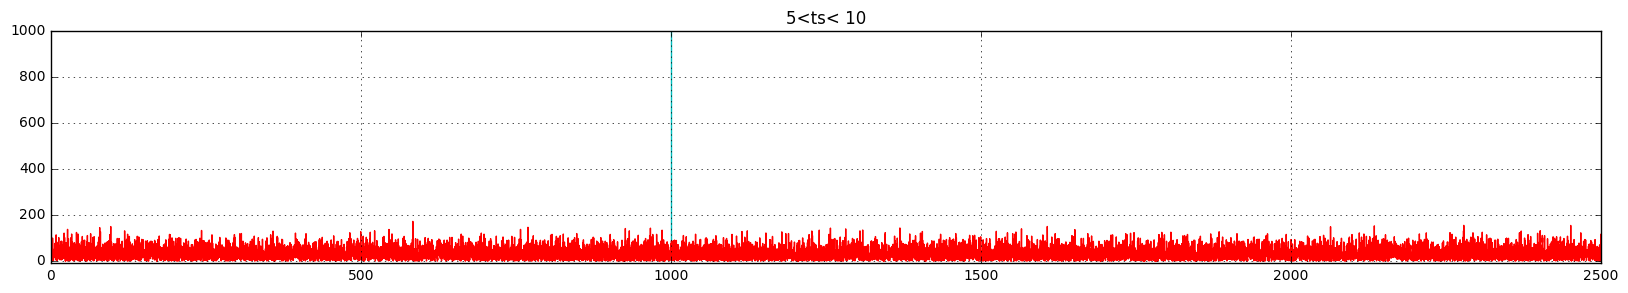

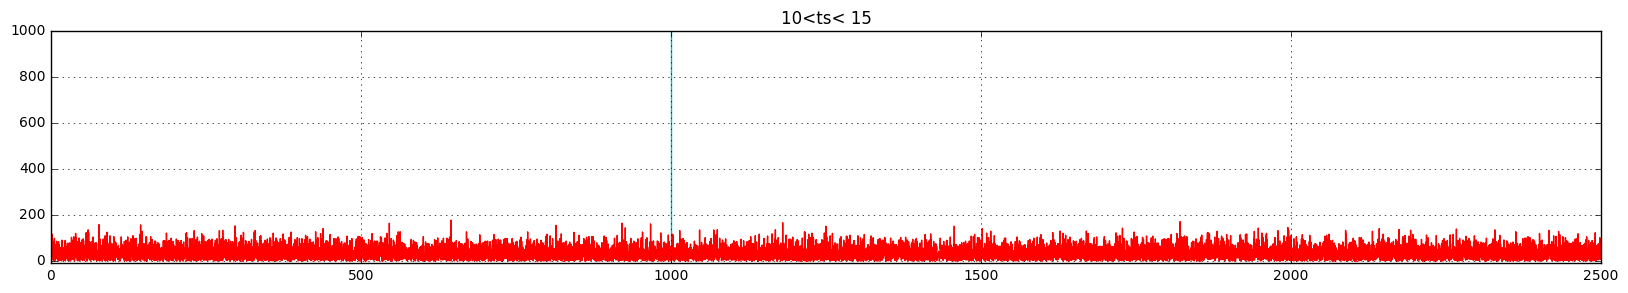

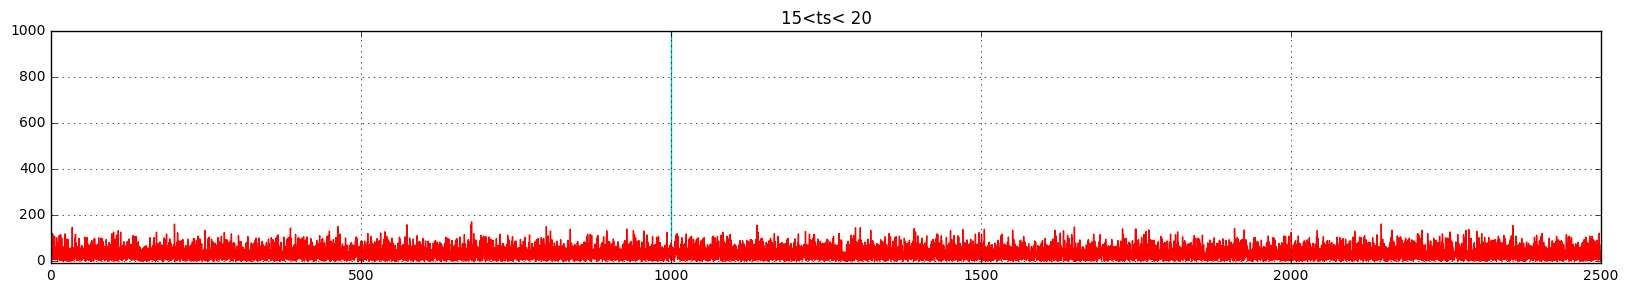

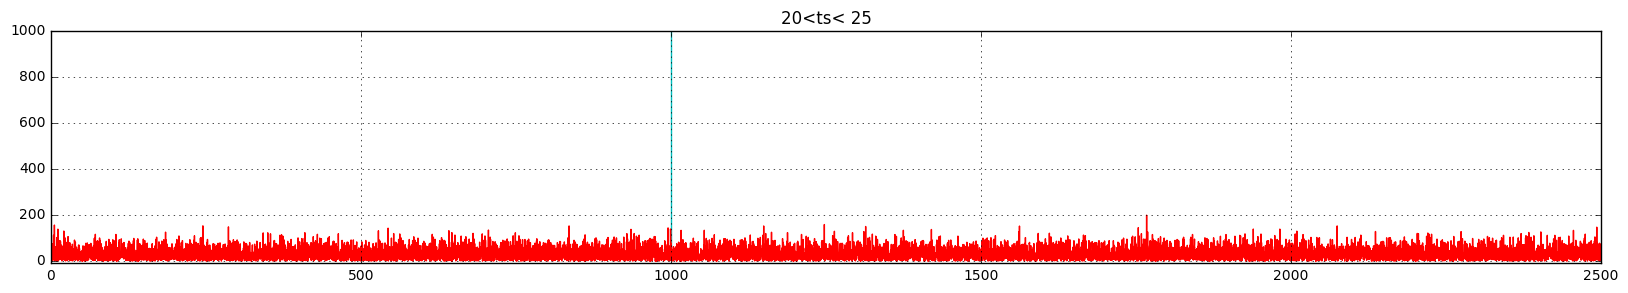

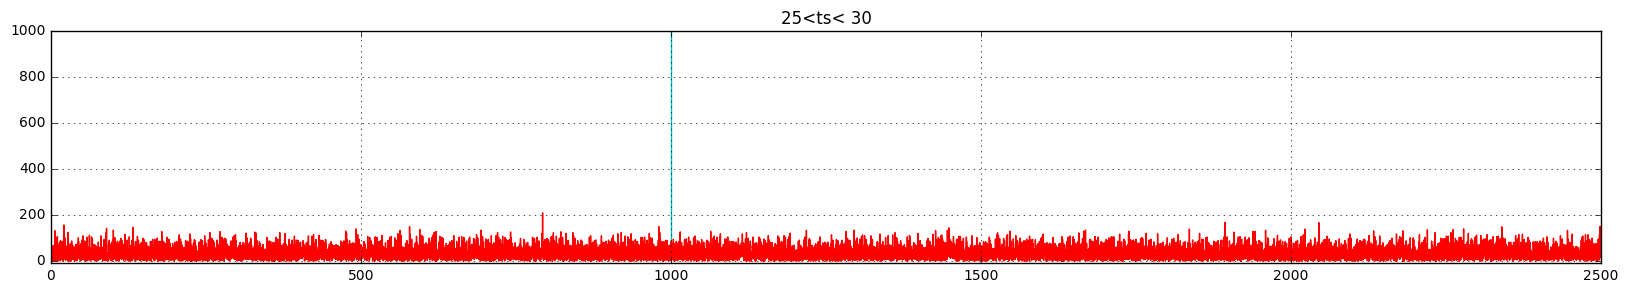

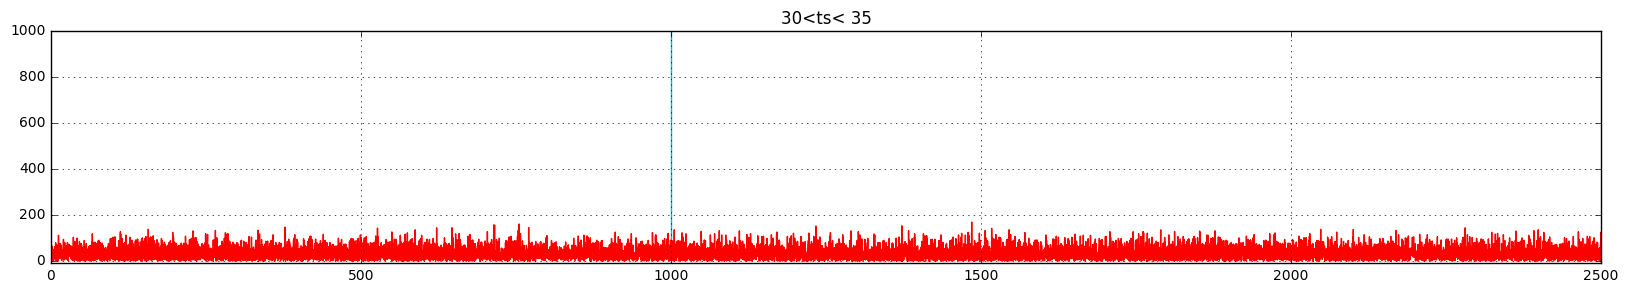

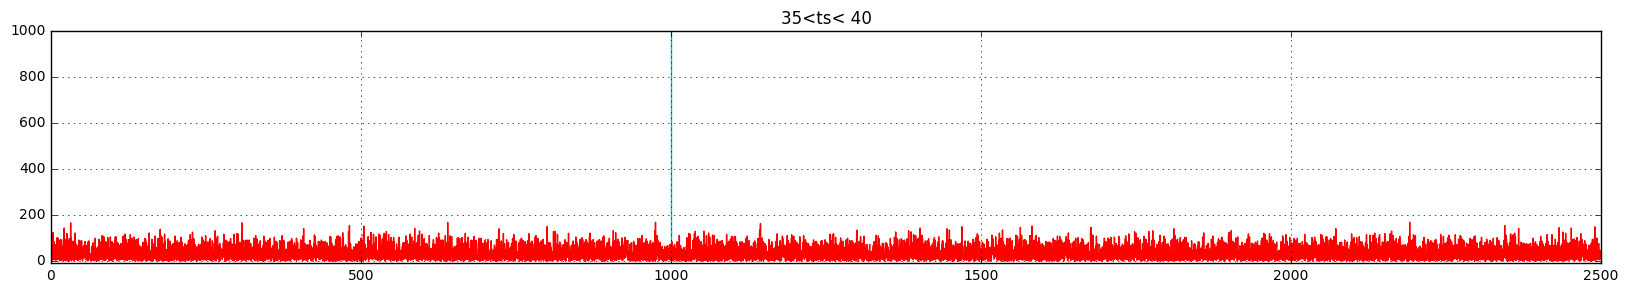

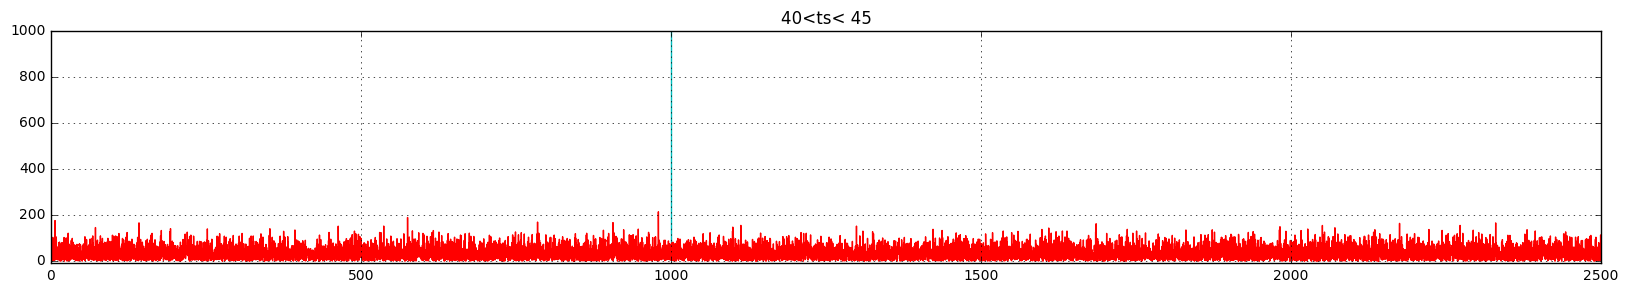

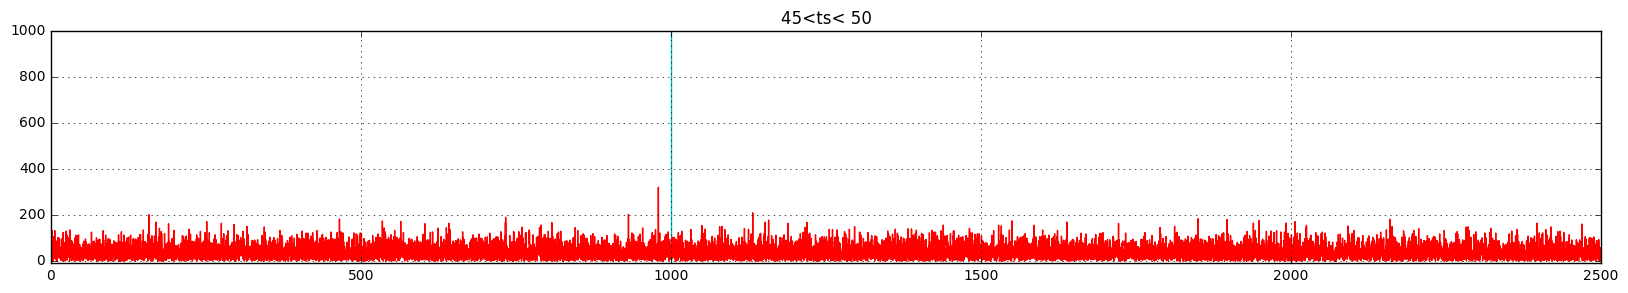

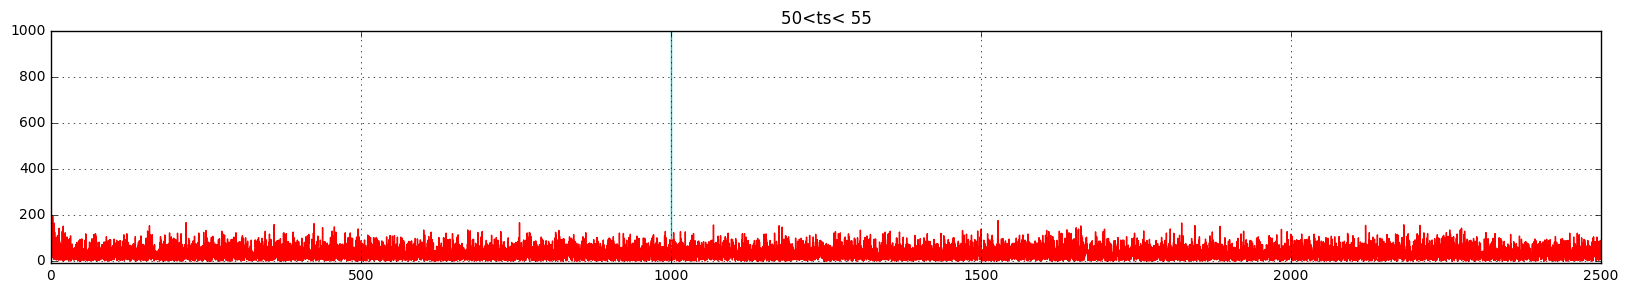

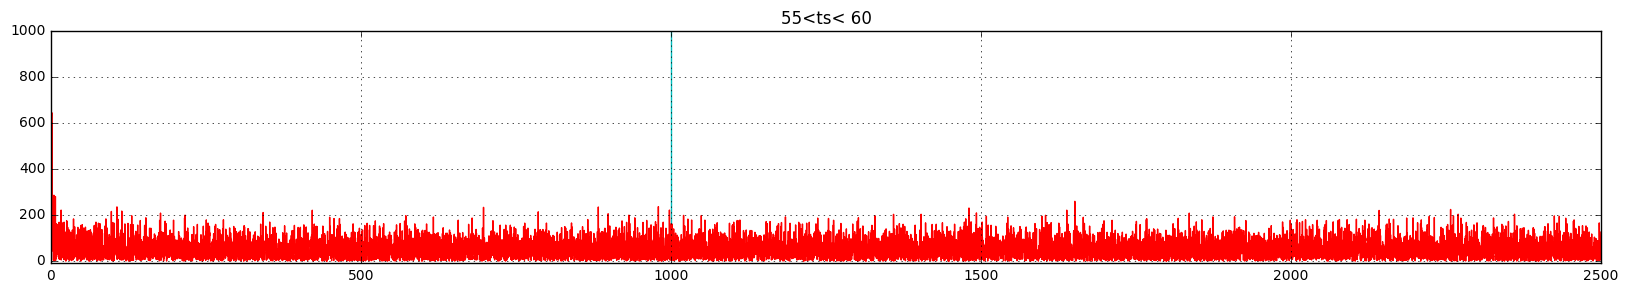

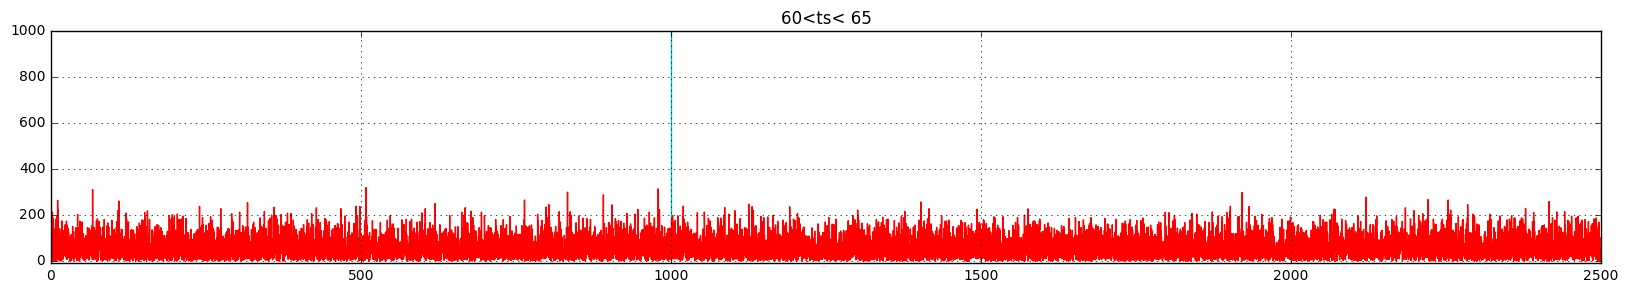

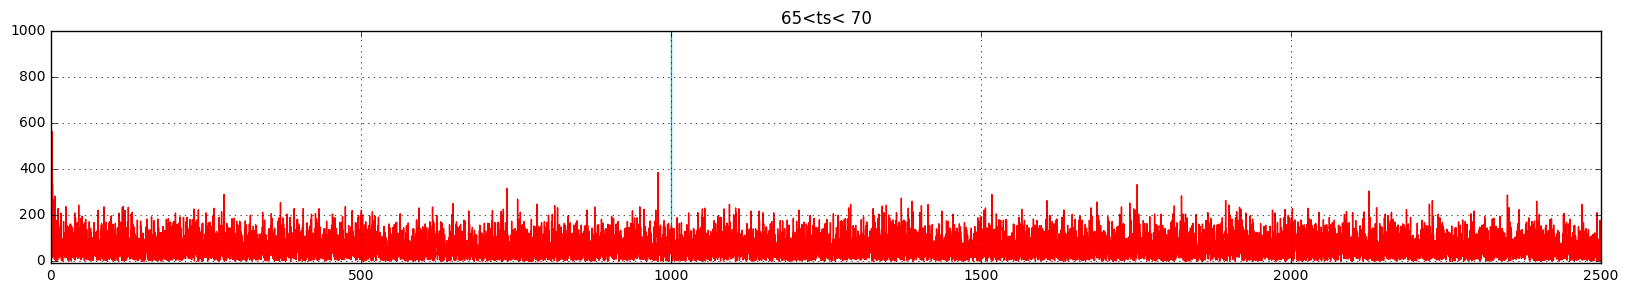

In [19]:
for i in range(int(ts.max()/5)):
    ts_truncate = ts[np.logical_and(ts>5*i, ts<5*(i+1))]
    plt.figure(figsize=(20,3))
    (freq, real_half) = get_fft(ts_truncate, t_bin)
    plt.plot(freq, real_half, 'r')
    plt.ylim(-10, 1000)
    plt.vlines(x= V_freq_applied, ymin=0, ymax=plt.yticks()[0][-1], color='c')
    plt.title('%d' % (5*i)+'<ts< %d' % (5*(i+1)))
    plt.grid()

## FFT score as function of time (with a sliding time window)

(0, 74.905053254531254)

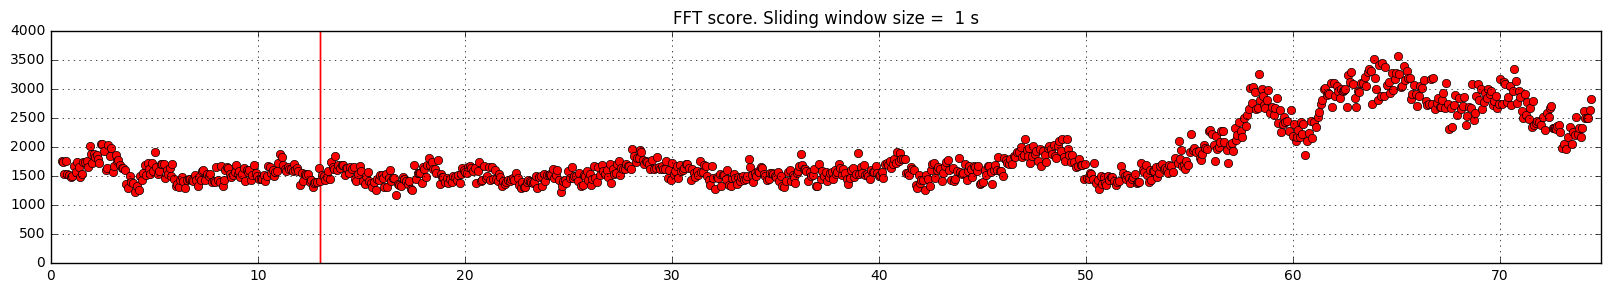

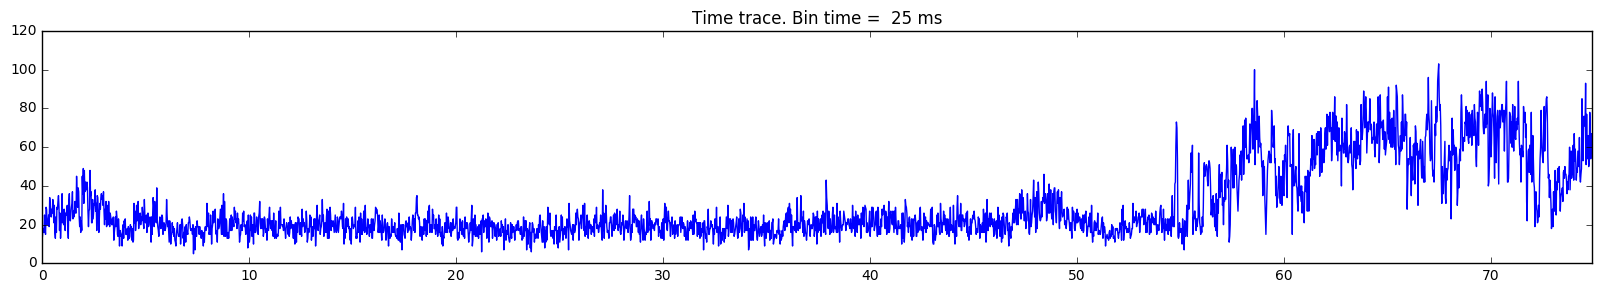

In [20]:
# Plot FFT score as function of time
plt.figure(figsize=(20,3))
t_window = 1
n_points = 1000
for t_start in np.linspace(0,ts.max()-t_window,n_points):
    ts_truncate = ts[np.logical_and(ts>t_start, ts<t_start+t_window)]
    (freq, real_half) = get_fft(ts_truncate, t_bin)
    t = np.mean(ts_truncate) 
    #score = np.sum(real_half[np.where(np.logical_and(freq>V_freq_applied*0.95, 
    #                                                 freq<V_freq_applied*1.05))])
    score = np.sum(real_half[np.where(np.logical_and(freq>extracted_freqs.mean()*0.95, 
                                                     freq<extracted_freqs.mean()*1.05))])
    plt.plot(t, score, 'ro')
plt.title('FFT score. Sliding window size = % d' % t_window +' s')
plt.grid()
plt.xlim(0, ts.max())
plt.vlines(x= voltage_start_time, ymin=0, ymax=plt.yticks()[0][-1], color='r')
plt.vlines(x= voltage_start_time, ymin=0, ymax=plt.yticks()[0][-1], color='r')


# Plot intensity time trace as reference
plt.figure(figsize=(20,3))
counts, bin_edge = np.histogram(ts, bins=np.arange(0,np.max(ts),0.025))
plt.plot(bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2, counts, 'b-')
plt.title('Time trace. Bin time = % d' % 25 +' ms')
plt.xlim(0, ts.max())

### Wrap data in selected time period with high FFT score

Time period: from 58s to 60s


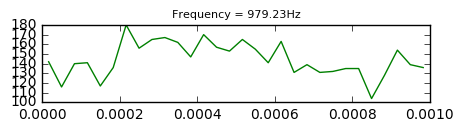

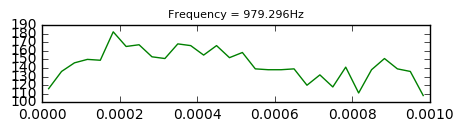

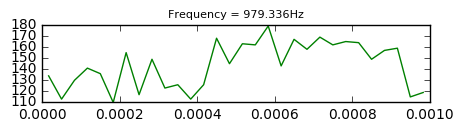

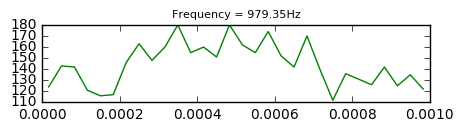

In [21]:
start, stop = (58,60)
ts_truncate = ts[np.logical_and(ts>start, ts<stop)]
print('Time period: from %d' % start +'s to %d' % stop+'s')
for period in periods:
    counts, bin_edge = np.histogram(ts_truncate%period, bins=np.arange(0,period,t_bin/6))
    plt.figure(figsize=(5,1))
    plt.plot(bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2, counts, 'g-')
    #plt.ylim(0, counts.max())
    plt.title('Frequency = {}Hz'.format(round(1/period, 3)), fontsize=8)

### Time trace in selected time period with high FFT score

Bin time = 0.000200 s


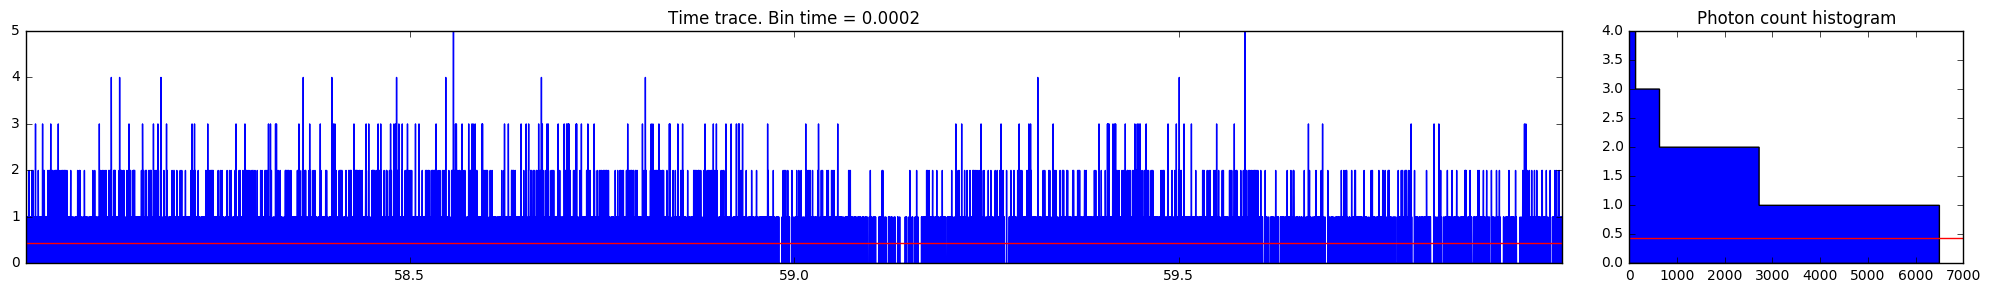

In [22]:
print('Bin time = %f s' % t_bin)
counts, bin_edge = np.histogram(ts_truncate, 
                                bins=np.arange(np.min(ts_truncate),np.max(ts_truncate),t_bin))

fig, ax = plt.subplots(1,5, figsize=(25,3))
ax0 = plt.subplot2grid((1,5), (0,0), colspan=4, rowspan=1)
ax1 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1)

ax0.plot(bin_edge[1:]-(bin_edge[1]-bin_edge[0])/2, counts)
ax0.set_xlim(bin_edge[0], bin_edge[-1])
ax0.set_title('Time trace. Bin time = {}'.format(t_bin))
ax0.axhline(np.mean(counts), color='r')

c, b, p = ax1.hist(counts, bins=np.arange(counts.min(),counts.max(),1), color='b', 
                   histtype='stepfilled', orientation='horizontal')
ax1.axhline(np.mean(counts), color='r')
ax1.set_title('Photon count histogram')